# Implementation of WGAN-GP
Reference: https://arxiv.org/pdf/1704.00028.pdf


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import scipy.misc

In [4]:
MODEL_NAME = 'WGAN-gp'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def to_cuda(x):
    return x.to(DEVICE)

In [18]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    for num in range(10):
        for i in range(10):
            z = to_cuda(torch.randn(1, n_noise))
            y_hat = G(z)
            line_img = torch.cat((line_img, y_hat.view(28, 28)), dim=1) if i > 0 else y_hat.view(28, 28)
        all_img = torch.cat((all_img, line_img), dim=0) if num > 0 else line_img
    img = all_img.cpu().data.numpy()
    return img

In [6]:
def n_critic(step, nc=5):
    if step < 25 or step % 500 == 0:
        return 100
    return nc

In [7]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer1(y_)
        y_ = self.layer2(y_)
        y_ = self.layer3(y_)
        return y_

In [8]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [9]:
D = to_cuda(Discriminator())
G = to_cuda(Generator())

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))]
)

In [11]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [12]:
batch_size = 64

In [13]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [14]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0.0, 0.9))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.0, 0.9))

In [15]:
max_epoch = 300 # need more than 300 epochs for training
step = 0
g_step = 0
n_noise = 100
p_coeff = 10 # lambda

In [16]:
D_labels = to_cuda(torch.ones(batch_size, 1)) # Discriminator Label to real
D_fakes = to_cuda(torch.zeros(batch_size, 1)) # Discriminator Label to fake

In [19]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        step += 1
                   
        ## Training Discriminator
        # Real data
        x = to_cuda(images)
        
        # Sampling
        z = to_cuda(torch.randn(batch_size, n_noise))
        x_fake = G(z)
                
        # Gradient Penalty (e.g. gradients w.r.t x_penalty)
        eps = to_cuda(torch.rand(batch_size, 1, 1, 1)) # x shape: (64, 1, 28, 28)
        x_penalty = eps*x + (1-eps)*x_fake
        x_penalty = x_penalty.view(x_penalty.size(0), -1)
        p_outputs = D(x_penalty)
        xp_grad = autograd.grad(outputs=p_outputs, inputs=x_penalty, grad_outputs=D_labels,
                                create_graph=True, retain_graph=True, only_inputs=True)
        grad_penalty = p_coeff * torch.mean(torch.pow(torch.norm(xp_grad[0], 2, 1) - 1, 2))
        
        # Wasserstein loss
        x_outputs = D(x)
        z_outputs = D(x_fake)
        D_x_loss = torch.mean(x_outputs)
        D_z_loss = torch.mean(z_outputs)
        D_loss = D_z_loss - D_x_loss + grad_penalty
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()
                    
        if step % n_critic(g_step) == 0:
            g_step += 1
            # Training Generator
            z = to_cuda(torch.randn(batch_size, n_noise))
            z_outputs = D(G(z))
            G_loss = torch.mean(-z_outputs, 0)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 1000 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, -D_loss.data[0], -G_loss.data[0]))
            
        if epoch % 5 == 0:
            G.eval()
            img = get_sample_image(G)
            scipy.misc.imsave('sample/{}_epoch_{}_type1.jpg'.format(MODEL_NAME, epoch), img)
            G.train()

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/300, Step: 1000, D Loss: 32.421409606933594, G Loss: 3.8607895374298096
Epoch: 2/300, Step: 2000, D Loss: 27.481861114501953, G Loss: 10.427570343017578
Epoch: 3/300, Step: 3000, D Loss: 11.777752876281738, G Loss: 2.700834274291992
Epoch: 4/300, Step: 4000, D Loss: 7.606339931488037, G Loss: 5.339910984039307
Epoch: 5/300, Step: 5000, D Loss: 4.887202739715576, G Loss: 5.274722099304199
Epoch: 6/300, Step: 6000, D Loss: 3.8848841190338135, G Loss: 5.174000263214111
Epoch: 7/300, Step: 7000, D Loss: 3.308317184448242, G Loss: 4.30143928527832
Epoch: 8/300, Step: 8000, D Loss: 3.177185297012329, G Loss: 4.367456436157227
Epoch: 9/300, Step: 9000, D Loss: 3.2354133129119873, G Loss: 4.0006184577941895
Epoch: 10/300, Step: 10000, D Loss: 3.361888885498047, G Loss: 1.377447485923767
Epoch: 11/300, Step: 11000, D Loss: 3.348159074783325, G Loss: 0.1197112575173378
Epoch: 12/300, Step: 12000, D Loss: 3.595661163330078, G Loss: -1.8982950448989868
Epoch: 13/300, Step: 13000, D Loss: 

Epoch: 107/300, Step: 101000, D Loss: 1.688525915145874, G Loss: 3.0105607509613037
Epoch: 108/300, Step: 102000, D Loss: 2.071834087371826, G Loss: 1.4367623329162598
Epoch: 109/300, Step: 103000, D Loss: 1.7366586923599243, G Loss: 2.517975330352783
Epoch: 110/300, Step: 104000, D Loss: 2.246958017349243, G Loss: 2.3840577602386475
Epoch: 112/300, Step: 105000, D Loss: 2.078842878341675, G Loss: 2.1413705348968506
Epoch: 113/300, Step: 106000, D Loss: 2.2253687381744385, G Loss: 1.3380357027053833
Epoch: 114/300, Step: 107000, D Loss: 1.9181996583938599, G Loss: 0.7760651111602783
Epoch: 115/300, Step: 108000, D Loss: 2.185868740081787, G Loss: 2.3104326725006104
Epoch: 116/300, Step: 109000, D Loss: 1.8771471977233887, G Loss: 2.297456741333008
Epoch: 117/300, Step: 110000, D Loss: 1.6639037132263184, G Loss: 2.6569411754608154
Epoch: 118/300, Step: 111000, D Loss: 1.8093984127044678, G Loss: 1.5812029838562012
Epoch: 119/300, Step: 112000, D Loss: 1.9695311784744263, G Loss: 2.7274

Epoch: 212/300, Step: 199000, D Loss: 1.6205874681472778, G Loss: 1.7785515785217285
Epoch: 213/300, Step: 200000, D Loss: 1.9641838073730469, G Loss: 1.1473100185394287
Epoch: 214/300, Step: 201000, D Loss: 1.2453465461730957, G Loss: 1.3317583799362183
Epoch: 215/300, Step: 202000, D Loss: 1.8684091567993164, G Loss: 1.5077457427978516
Epoch: 216/300, Step: 203000, D Loss: 1.5113515853881836, G Loss: 0.852348804473877
Epoch: 217/300, Step: 204000, D Loss: 1.5024529695510864, G Loss: 1.3097288608551025
Epoch: 218/300, Step: 205000, D Loss: 1.7717453241348267, G Loss: 1.8582208156585693
Epoch: 219/300, Step: 206000, D Loss: 1.3914272785186768, G Loss: 1.7953325510025024
Epoch: 220/300, Step: 207000, D Loss: 1.3503193855285645, G Loss: 1.3766549825668335
Epoch: 221/300, Step: 208000, D Loss: 1.1814839839935303, G Loss: 2.0843772888183594
Epoch: 223/300, Step: 209000, D Loss: 1.7548142671585083, G Loss: 1.7744446992874146
Epoch: 224/300, Step: 210000, D Loss: 1.4989140033721924, G Loss: 

## Sample

In [20]:
import scipy.misc

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


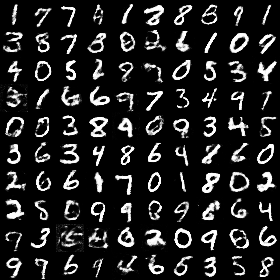

In [25]:
# generation to image
G.eval()
scipy.misc.toimage(get_sample_image(G))

In [160]:
# generation to image
z = to_cuda(torch.randn(1, n_noise))
fakeimg = G(z).view(28, 28)
img = fakeimg.cpu().data.numpy()
scipy.misc.toimage(img)

/home/yangyangii/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


In [15]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [16]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_gp.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_gp.pth.tar')